In [1]:
from datetime import datetime
from time import time

import numpy as np
import pandas as opd

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import warnings
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
from fastai.utils.show_install import show_install; show_install()



```text
=== Software === 
python        : 3.6.6
fastai        : 1.0.57
fastprogress  : 0.1.21
torch         : 1.2.0
torch cuda    : 10.0.130 / is available
torch cudnn   : 7602 / is enabled

=== Hardware === 
torch devices : 1
  - gpu0      : Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-5.15.133+-x86_64-with-debian-9.9
distro        : #1 SMP Tue Dec 19 13:14:11 UTC 2023
conda env     : Unknown
python        : /opt/conda/bin/python
sys.path      : /kaggle/lib/kagglegym
/kaggle/lib
/kaggle/input
/opt/conda/lib/python36.zip
/opt/conda/lib/python3.6
/opt/conda/lib/python3.6/lib-dynload

/root/.local/lib/python3.6/site-packages
/opt/conda/lib/python3.6/site-packages
/opt/conda/lib/python3.6/site-packages/nolearn-0.6.1.dev0-py3.6.egg
/opt/conda/lib/python3.6/site-packages/tabulate-0.8.3-py3.6.egg
/opt/conda/lib/python3.6/site-packages/gdbn-0.1-py3.6.egg
/opt/conda/lib/python3.6/site-packages/gnumpy-0.2-py3.6.egg
/opt/conda/lib/python3.6/site-packages/PyBrain-0.3.3-py3.6

In [3]:
!nvidia-smi

In [4]:
def fmt_now():
    return datetime.today().strftime('%Y%m%d-%H%M%S')

## EDA

In [5]:
path = Path('../input')
path.ls()

[PosixPath('../input/sample_submission.csv'),
 PosixPath('../input/train_images'),
 PosixPath('../input/train.csv'),
 PosixPath('../input/test_images')]

In [6]:
path_img = path/'train_images'

fnames_train = get_image_files(path_img)
for f in fnames_train[:3]:
    print(f)
print('\nTotal number of training images: {}'.format(len(fnames_train)))

../input/train_images/397c2fd.jpg
../input/train_images/1ea27d0.jpg
../input/train_images/359b9af.jpg

Total number of training images: 5546


In [7]:
path_test = path/'test_images'

fnames_test = get_image_files(path_test)
for f in fnames_test[:3]:
    print(f)
print('\nTotal number of test images: {}'.format(len(fnames_test)))

../input/test_images/cb6c11f.jpg
../input/test_images/efe623a.jpg
../input/test_images/80688f9.jpg

Total number of test images: 3698


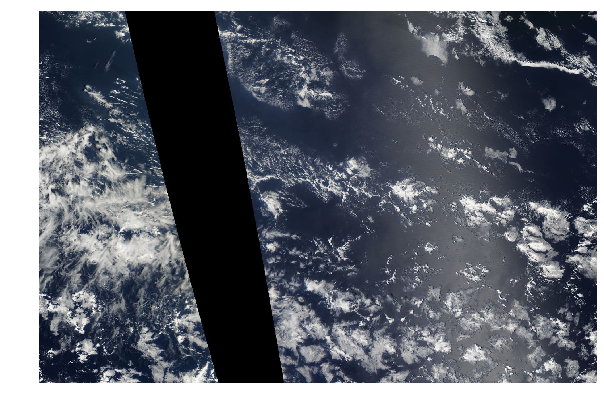

In [8]:
img_f = fnames_train[2]
img = open_image(img_f)
img.show(figsize=(10, 10))

In [9]:
def split_img_label(img_lbl):
    """Return image and label from filename """
    s = img_lbl.split("_")
    assert len(s) == 2
    return s[0], s[1]

In [10]:
train = pd.read_csv(f'{path}/train.csv')
train['Image'] = train['Image_Label'].apply(lambda img_lbl: split_img_label(img_lbl)[0])
train['Label'] = train['Image_Label'].apply(lambda img_lbl: split_img_label(img_lbl)[1])
del train['Image_Label']
train.head(5)

EncodedPixels        Image   Label
0  264918 937 266318 937 267718 937 269118 937 27...  0011165.jpg    Fish
1  1355565 1002 1356965 1002 1358365 1002 1359765...  0011165.jpg  Flower
2                                                NaN  0011165.jpg  Gravel
3                                                NaN  0011165.jpg   Sugar
4  233813 878 235213 878 236613 878 238010 881 23...  002be4f.jpg    Fish

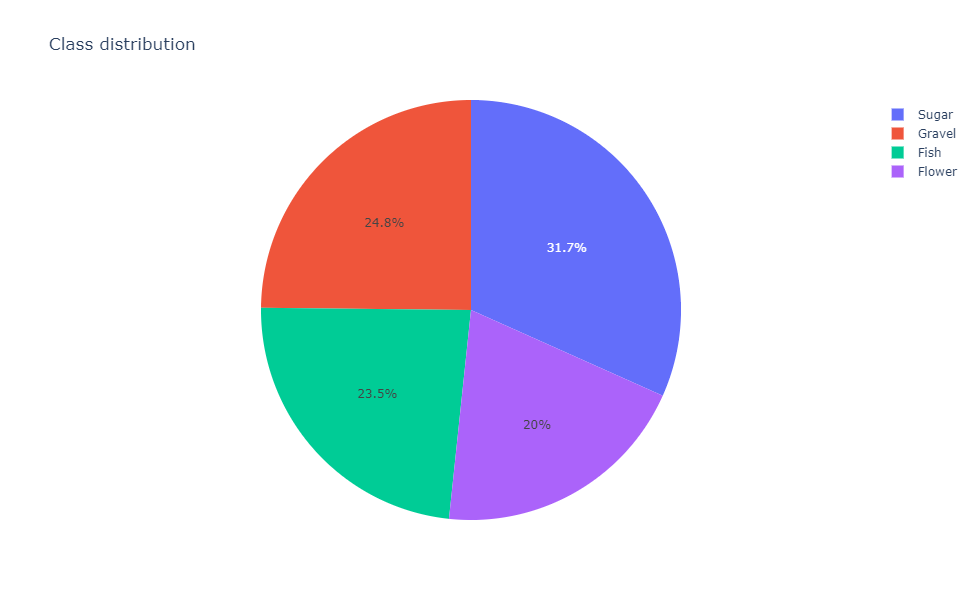

In [12]:
train_with_mask = train.dropna(subset=['EncodedPixels'])

#colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

fig = go.Figure(data=[go.Pie(labels=train_with_mask['Label'].value_counts().index, 
                             values=train_with_mask['Label'].value_counts().values)])

fig.update_traces(hoverinfo="label+percent+name")

fig.update_layout(height=600, width=900, title = 'Class distribution')

fig.show()

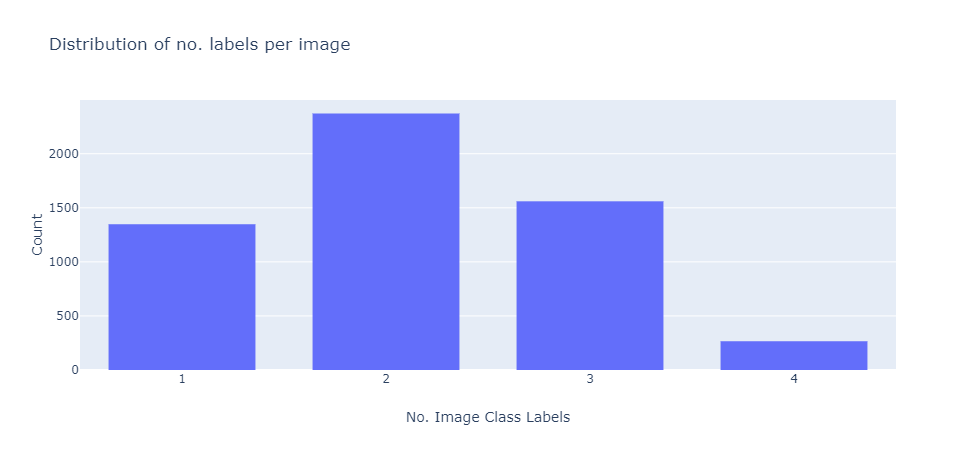

In [13]:
class_counts = train.dropna(subset=['EncodedPixels']).groupby('Image')['Label'].nunique()

fig = go.Figure()

fig.add_trace(
    go.Histogram(
        x = class_counts,
        xbins=dict(
        start=0.5,
        end=4.5,
        size=1
        ),
    )
)

fig.update_layout(height=450, width=900, title = 'Distribution of no. labels per image')

fig.update_layout(
    xaxis_title_text='No. Image Class Labels', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.update_xaxes(tickvals=[1, 2, 3, 4])

fig.show()

In [14]:
train = train.pivot(index='Image', columns='Label', values='EncodedPixels')
assert len(train) == len(fnames_train)
train.head()

Label                                                     Fish  \
Image                                                            
0011165.jpg  264918 937 266318 937 267718 937 269118 937 27...   
002be4f.jpg  233813 878 235213 878 236613 878 238010 881 23...   
0031ae9.jpg  3510 690 4910 690 6310 690 7710 690 9110 690 1...   
0035239.jpg                                                NaN   
003994e.jpg  2367966 18 2367985 2 2367993 8 2368002 62 2369...   

Label                                                   Flower  \
Image                                                            
0011165.jpg  1355565 1002 1356965 1002 1358365 1002 1359765...   
002be4f.jpg  1339279 519 1340679 519 1342079 519 1343479 51...   
0031ae9.jpg  2047 703 3447 703 4847 703 6247 703 7647 703 9...   
0035239.jpg  100812 462 102212 462 103612 462 105012 462 10...   
003994e.jpg                                                NaN   

Label                                                   Gravel  \
Image                                                            
0011165.jpg                                                NaN   
002be4f.jpg                                                NaN   
0031ae9.jpg                                                NaN   
0035239.jpg  65400 380 66800 380 68200 380 69600 380 71000 ...   
003994e.jpg  353317 416 354717 416 356117 416 357517 416 35...   

Label                                                    Sugar  
Image                                                           
0011165.jpg                                                NaN  
002be4f.jpg  67495 350 68895 350 70295 350 71695 350 73095 ...  
0031ae9.jpg  658170 388 659570 388 660970 388 662370 388 66...  
0035239.jpg                                                NaN  
003994e.jpg  28011 489 29411 489 30811 489 32211 489 33611 ...

### Broken images

In [15]:
def show_img_fn(fname, figsize=(10, 10)):
    img = open_image(fname)
    img.show(figsize=figsize)

In [16]:
def show_img_info(fname):
    show_img_fn(path_img/fname)
    display(train.loc[[fname]])

In [17]:
unusual_imgs = ["1588d4c.jpg", "c0306e5.jpg", "c26c635.jpg", "fa645da.jpg", "41f92e5.jpg", "e5f2f24.jpg"]

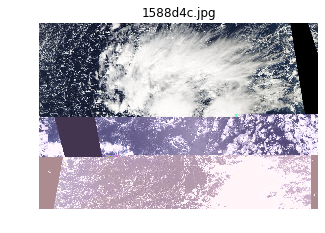

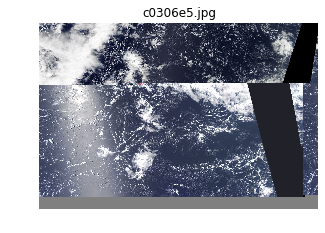

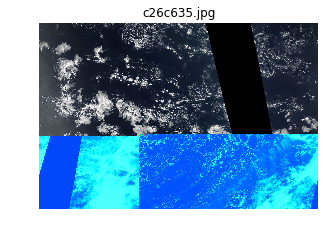

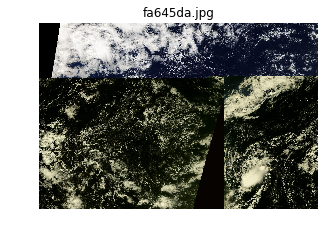

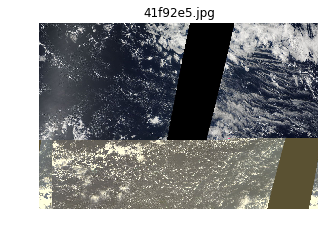

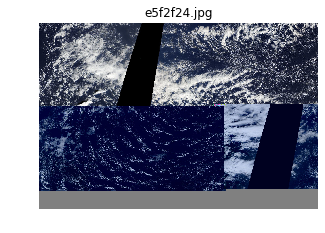

In [19]:
for fname in unusual_imgs:
    img = open_image(path_img/fname)
    img.show(figsize=(5, 5), title=fname)     

### Convert masks from/to RLE

In [20]:
train_img_dims = (1400, 2100)

In [21]:
def rle_to_mask(rle, shape):
    mask_img = open_mask_rle(rle, shape)
    mask = mask_img.px.permute(0, 2, 1)
    return mask

In [22]:
def mask_to_rle(mask):
    """ Convert binary 'mask' to RLE string """
    return rle_encode(mask.numpy().T)

torch.Size([1, 1400, 2100])


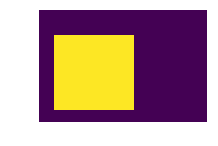

In [23]:
def test_mask_rle():
    """ test case for mask RLE encode/decode"""
    mask_rle = train.iloc[0]['Fish']
    mask = rle_to_mask(mask_rle, train_img_dims)
    mask_rle_enc = mask_to_rle(mask)
    assert mask_rle_enc == mask_rle
    
    print(mask.shape)
    Image(mask).show()
    
test_mask_rle()

## Load images

In [24]:
item_list = (SegmentationItemList
            .from_df(df=train.reset_index(), path=path_img, cols='Image')
             #.use_partial_data(sample_pct=0.1)
            .split_by_rand_pct(0.2)
            )

In [25]:
class MultiLabelImageSegment(ImageSegment):
    """Store overlapping masks in separate image channels"""

    def show(self, ax:plt.Axes=None, figsize:tuple=(3,3), title:Optional[str]=None, hide_axis:bool=True,
        cmap:str='tab20', alpha:float=0.5, class_names=None, **kwargs):
        "Show the masks on `ax`."
             
        # put all masks into a single channel
        flat_masks = self.px[0:1, :, :].clone()
        for idx in range(1, self.shape[0]): # shape CxHxW
            mask = self.px[idx:idx+1, :, :] # slice tensor to a single mask channel
            # use powers of two for class codes to keep them distinguishable after sum 
            flat_masks += mask * 2**idx
        
        # use same color normalization in image and legend
        norm = matplotlib.colors.Normalize(vmin=0, vmax=2**self.shape[0]-1)
        ax = show_image(Image(flat_masks), ax=ax, hide_axis=hide_axis, cmap=cmap, norm=norm,
                        figsize=figsize, interpolation='nearest', alpha=alpha, **kwargs)
        
     # custom legend, see https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
        cm = matplotlib.cm.get_cmap(cmap)
        legend_elements = []
        for idx in range(self.shape[0]):
            c = 2**idx
            label = class_names[idx] if class_names is not None else f"class {idx}"
            line = Line2D([0], [0], color=cm(norm(c)), label=label, lw=4)
            legend_elements.append(line)
        ax.legend(handles=legend_elements)
        
        # debug info
        # ax.text(10, 10, f"px={self.px.size()}", {"color": "white"})
        
        if title: ax.set_title(title)

    def reconstruct(self, t:Tensor): 
        return MultiClassImageSegment(t)
        

In [26]:
# source: https://forums.fast.ai/t/unet-how-to-get-4-channel-output/54674/4
def bce_logits_floatify(input, target, reduction='mean'):
    return F.binary_cross_entropy_with_logits(input, target.float(), reduction=reduction)

In [27]:
class MultiLabelSegmentationLabelList(SegmentationLabelList):
    """Return a single image segment with all classes"""
    # adapted from https://forums.fast.ai/t/how-to-load-multiple-classes-of-rle-strings-from-csv-severstal-steel-competition/51445/2
    
    def __init__(self, items:Iterator, src_img_size=None, classes:Collection=None, **kwargs):
        super().__init__(items=items, classes=classes, **kwargs)
        self.loss_func = bce_logits_floatify
        self.src_img_size = src_img_size
        # add attributes to copy by new() 
        self.copy_new += ["src_img_size"]
    
    def open(self, rles):        
        # load mask at full resolution
        masks = torch.zeros((len(self.classes), *self.src_img_size)) # shape CxHxW
        for i, rle in enumerate(rles):
            if isinstance(rle, str):  # filter out NaNs
                masks[i] = rle_to_mask(rle, self.src_img_size)
        return MultiLabelImageSegment(masks)
    
    def analyze_pred(self, pred, thresh:float=0.0):
        # binarize masks
        return (pred > thresh).float()
    
    
    def reconstruct(self, t:Tensor): 
        return MultiLabelImageSegment(t)

In [28]:
class_names = ["Fish", "Flower", "Gravel", "Sugar"]

In [29]:
def get_masks_rle(img):
    """Get RLE-encoded masks for this image"""
    img = img.split("/")[-1]  # get filename only
    return train.loc[img, class_names].to_list()

In [30]:
img_size = (84, 132)  # use multiple of 4
img_size

(84, 132)

In [31]:
classes = [0, 1, 2, 3] # no need for a "void" class: if a pixel isn't in any mask, it is not labelled
item_list = item_list.label_from_func(func=get_masks_rle, label_cls=MultiLabelSegmentationLabelList, 
                                      classes=classes, src_img_size=train_img_dims)

In [32]:
item_list = item_list.add_test_folder(path_test, label="")

In [33]:

batch_size = 8

# TODO add data augmentation
tfms = ([], [])
# tfms = get_transforms()

item_list = item_list.transform(tfms, tfm_y=True, size=img_size)

In [34]:
data = (item_list
        .databunch(bs=batch_size)
        .normalize(imagenet_stats) # use same stats as pretrained model
       )  
assert data.test_ds is not None

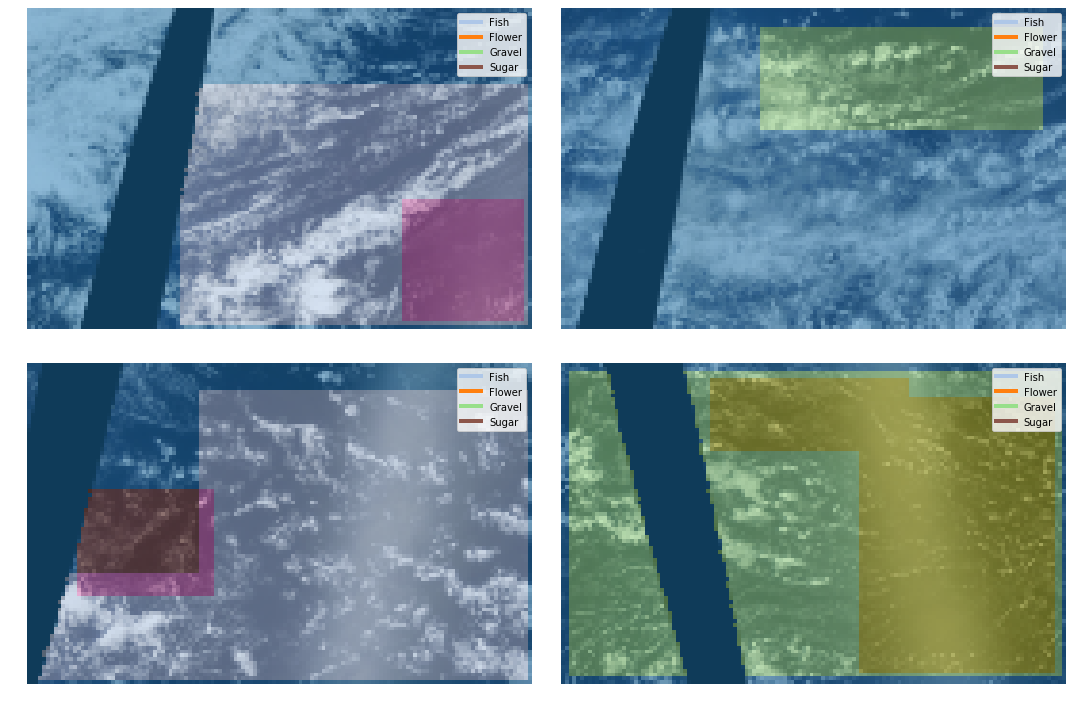

In [35]:
data.show_batch(2, figsize=(15, 10), class_names=class_names)

## Training

In [36]:
def dice_metric(pred, targs, threshold=0):
    pred = (pred > threshold).float()
    targs = targs.float()  # make sure target is float too
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

In [37]:
metrics = [dice_metric]

callback_fns = [
    # update a graph of learner stats and metrics after each epoch
    ShowGraph,

    # save model at every metric improvement
    partial(SaveModelCallback, every='improvement', monitor='dice_metric', name=f"{fmt_now()}_unet_resnet18_stage1_best"),
    
    # stop training if metric no longer improve
    partial(EarlyStoppingCallback, monitor='dice_metric', min_delta=0.01, patience=2),
]

learn = unet_learner(data, models.resnet18, metrics=metrics, wd=1e-2, callback_fns=callback_fns)
learn.model_dir = "/kaggle/working/"  # point to writable directory

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 101MB/s] 


In [38]:
learn.loss_func

<function __main__.bce_logits_floatify(input, target, reduction='mean')>

In [39]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 42, 66]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 42, 66]         128        True      
______________________________________________________________________
ReLU                 [64, 42, 66]         0          False     
______________________________________________________________________
MaxPool2d            [64, 21, 33]         0          False     
______________________________________________________________________
Conv2d               [64, 21, 33]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 21, 33]         128        True      
______________________________________________________________________
ReLU                 [64, 21, 33]         0          False     
__________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


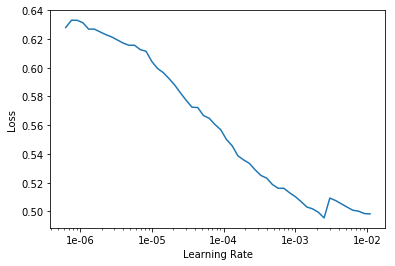

In [40]:
learn.lr_find()
learn.recorder.plot()

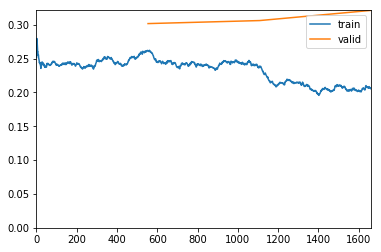

Better model found at epoch 0 with dice_metric value: 0.5109539031982422.


In [42]:
learn.fit_one_cycle(3, max_lr=1e-4)

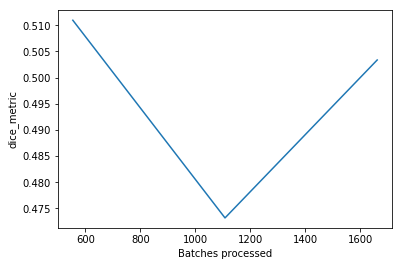

In [43]:
learn.recorder.plot_metrics()

In [44]:
learn.save(f"{fmt_now()}_unet_resnet18_stage1", return_path=True)

PosixPath('/kaggle/working/20240321-184705_unet_resnet18_stage1.pth')

In [45]:
!ls -lth {learn.model_dir}

total 661M
-rw-r--r-- 1 root root 271M Mar 21 18:47 20240321-184705_unet_resnet18_stage1.pth
-rw-r--r-- 1 root root 271M Mar 21 18:30 20240321-171549_unet_resnet18_stage1_best.pth
-rw-r--r-- 1 root root 119M Mar 21 17:16 tmp.pth


### unfreeze and differential learing rate

In [47]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


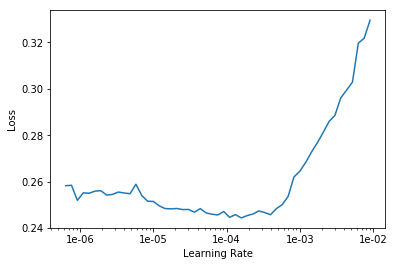

In [48]:
learn.lr_find()
learn.recorder.plot()

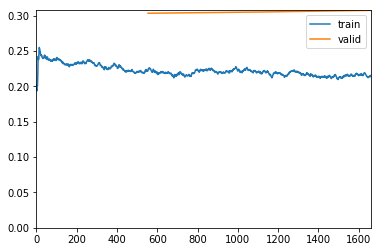

Better model found at epoch 0 with dice_metric value: 0.5141023397445679.


In [49]:
learn.fit_one_cycle(3, max_lr=slice(5e-7, 5e-6))

In [50]:
learn.save(f"{fmt_now()}_unet_resnet18_stage2", return_path=True)

PosixPath('/kaggle/working/20240321-191322_unet_resnet18_stage2.pth')

## Further tuning with larger images

In [51]:
img_size = (336, 528)
item_list = item_list.label_from_func(func=get_masks_rle, label_cls=MultiLabelSegmentationLabelList, 
                                      classes=classes, src_img_size=train_img_dims)
item_list = item_list.add_test_folder(path_test, label="")
batch_size = 8
tfms = ([], [])
item_list = item_list.transform(tfms, tfm_y=True, size=img_size)

In [52]:
data = (item_list
        .databunch(bs=batch_size)
        .normalize(imagenet_stats) # use same stats as pretrained model
       )  
assert data.test_ds is not None

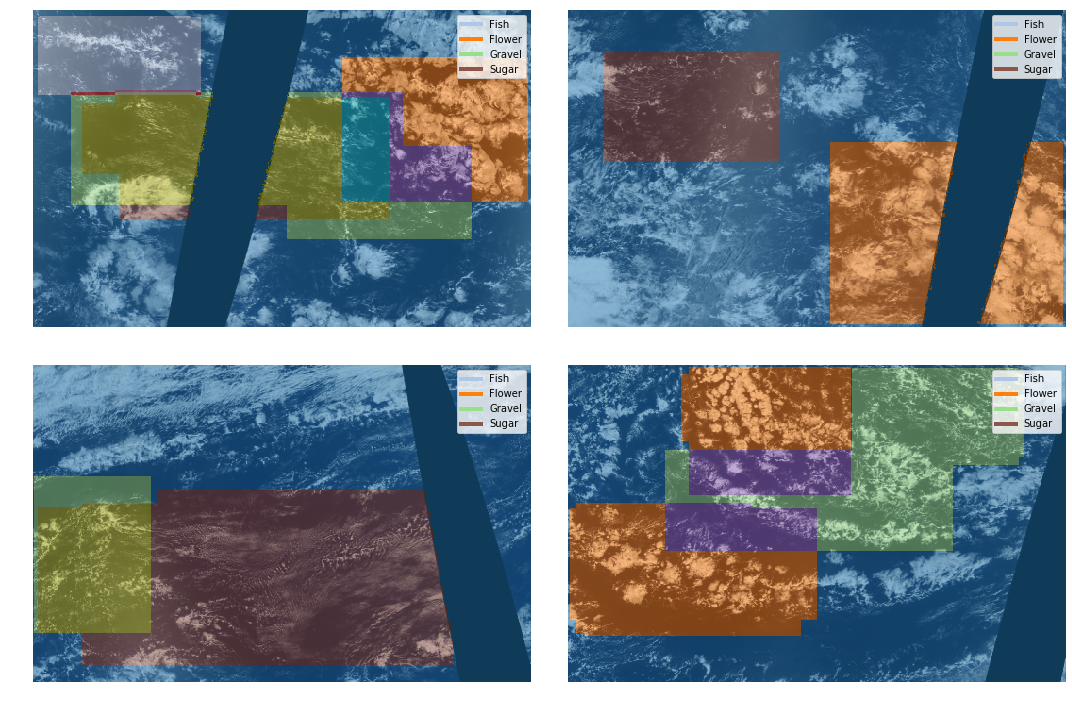

In [53]:
data.show_batch(2, figsize=(15, 10), class_names=class_names)

In [54]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 336, 528])

In [55]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


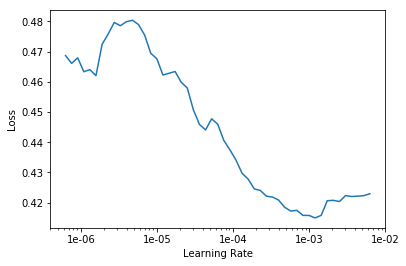

In [56]:
learn.lr_find()
learn.recorder.plot()

In [57]:
lr = 2e-4

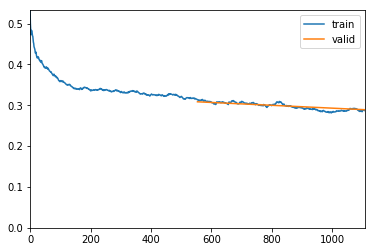

Better model found at epoch 0 with dice_metric value: 0.4211297333240509.
Better model found at epoch 1 with dice_metric value: 0.5026227831840515.


In [60]:
learn.fit_one_cycle(2, slice(lr))

In [61]:
lr=5e-5

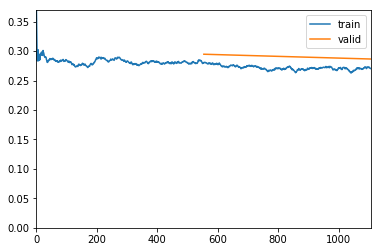

Better model found at epoch 0 with dice_metric value: 0.45047783851623535.
Better model found at epoch 1 with dice_metric value: 0.5222658514976501.


In [62]:
learn.fit_one_cycle(2, slice(lr))

In [63]:
learn.save(f"{fmt_now()}_unet_resnet18_stage3", return_path=True)

PosixPath('/kaggle/working/20240321-200009_unet_resnet18_stage3.pth')

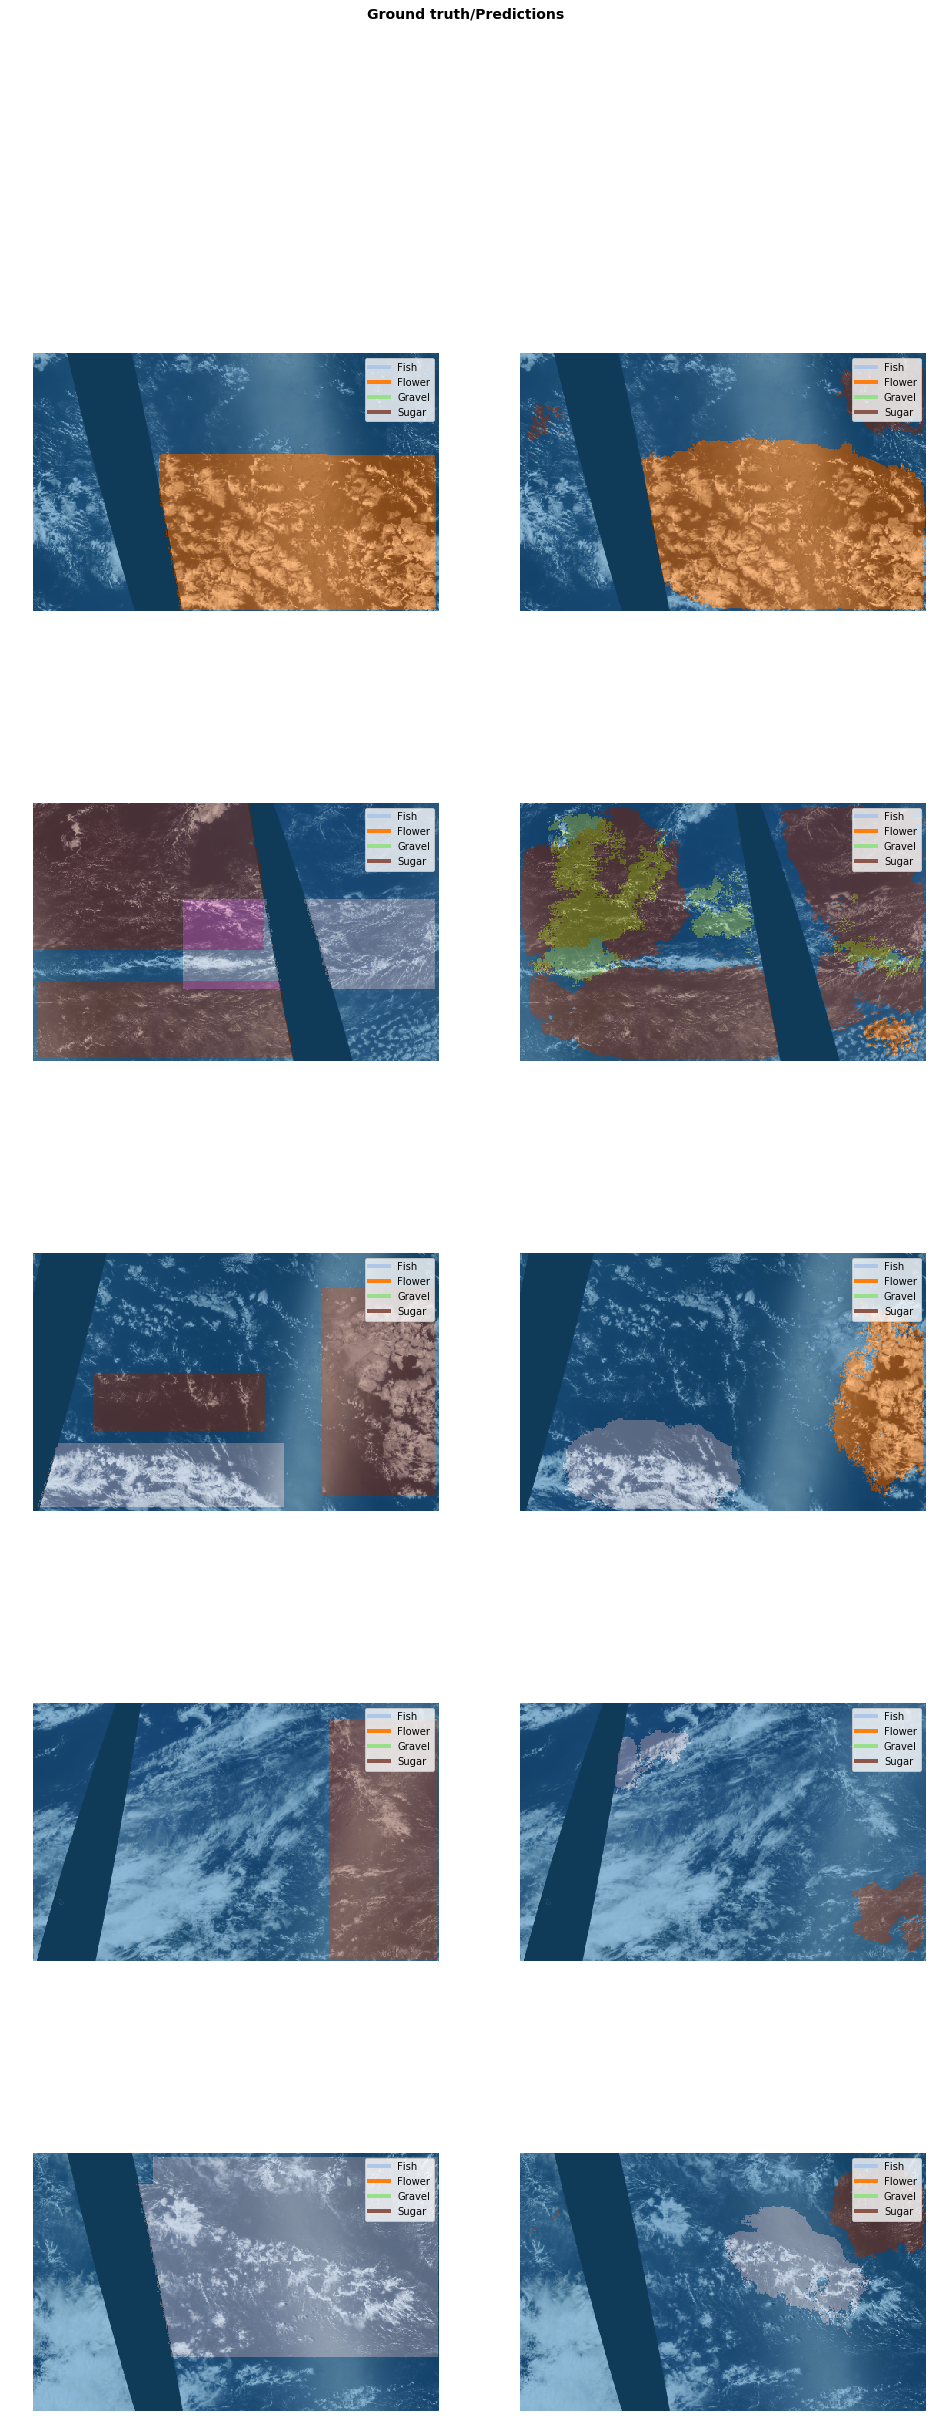

In [64]:
learn.show_results(imgsize=8, class_names=class_names)